In [1]:
%matplotlib inline

# Triangulation

This notebook will showcase how one may use the Nowcast Library to generate dynamically lagged data based on wind, bearing and distance between two geographically situated locations using the `dynlag` and `gis` submodules of the Nowcast Library.

"Dynamically lagging" in this context consists in dynamically shifting in time a particular quantity ("DIMM Seeing [arcsec]") measured at a source location (Paranal) to simulate the same quantity at a target location (Ventarrones). This shifting is dynamic because it depends on the wind measured at the source location, in particular how fast it is blowing and how aligned its direction is with the bearing between the source and the target locations. This is because it is assumed that the wind could transport the quantity in between sites.

## Imports

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nowcastlib as ncl

In [3]:
sns.set_style("ticks")
sns.set_context("notebook")

In [4]:
plt.close("all")

## The Data

### Time Series Data

As alluded to earlier, dynamically lagging a quantity requires a time-series data-set with columns containing the quantity we wish to simulate, the wind speed and the wind direction. In our case, these quantities came from different datasets which therefore required synchronization. Since data synchronization is covered in [rawdata.ipynb](./rawdata.ipynb), we are omitting the synchronization process from this notebook and directly loading the interpolated synchronized data-frame along with the correctly sized gap mask that was produced in the process. Readers are strongly encouraged to read [rawdata.ipynb](./rawdata.ipynb) if they find themselves confused about this.

In [5]:
data_df = pd.read_csv(
    "data/triangulation/p_v/output/wind_and_dimm.csv",
    usecols=[
        "Date time",
        "Wind Speed at 30m [m/s]",
        "Wind Direction at 30m (0/2pi) [rad]",
        "Wind Direction at 30m (0/360) [deg]",
        "DIMM Seeing [arcsec]",
        "Target RA [deg]",
        "Target DEC [deg]",
    ],
    parse_dates=True,
    index_col="Date time",
)
data_df.index.freq = pd.infer_freq(data_df.index)

In [6]:
# visualizing
data_df.head()

,Target RA [deg],Target DEC [deg],DIMM Seeing [arcsec],Wind Direction at 30m (0/360) [deg],Wind Speed at 30m [m/s],Wind Direction at 30m (0/2pi) [rad]
Date time,,,,,,
2016-04-05 23:50:00,78.6333,-8.20167,1.0940,20.0,5.33,0.349066
2016-04-05 23:51:00,78.6333,-8.20167,1.1320,22.0,6.00,0.383972
2016-04-05 23:52:00,78.6333,-8.20167,1.2065,22.0,5.58,0.383972
2016-04-05 23:53:00,78.6333,-8.20167,1.2810,19.0,5.20,0.331613
2016-04-05 23:54:00,78.6333,-8.20167,1.0880,21.0,5.25,0.366519


In [7]:
final_mask = np.load("data/triangulation/p_v/output/wind_and_dimm_mask.npy")

### Geographical Data

In [8]:
# constants
PARANAL_LAT_LON = np.array([-24.6272, -70.4039])
VENTARRONES_LAT_LON = np.array([-24.351867, -70.224139])
EARTH_RADIUS_M = 6.3710e6  # using mean radius

In [9]:
# collect Lat and Long coords of sites into single Dataframe
coords_df = pd.DataFrame(
    np.array([PARANAL_LAT_LON, VENTARRONES_LAT_LON]),
    columns=["Latitude", "Longitude"],
    index=["Paranal", "Ventarrones"],
)

## Processing

### Further Geographical Calculations

Here we make use of Nowcast Library's `gis` submodule to calculate the distance between our two sites, as well as the bearing from the source to the target.

We will need these quantities to determine how aligned the wind is with the bearing and how far it will be transporting whatever quantity we are simulating.

In [10]:
# Calculate great circle distance to Ventarrones
orientation_df = coords_df.copy()
orientation_df["GCD to Ventarrones [m]"] = coords_df.apply(
    lambda x: ncl.gis.great_circle_distance(
        x, coords_df.loc["Ventarrones"][["Latitude", "Longitude"]], EARTH_RADIUS_M
    ),
    axis=1,
)
# Calculate initial bearing to Ventarrones
orientation_df["Initial Bearing to Ventarrones [radians]"] = coords_df.apply(
    lambda x: ncl.gis.initial_bearing(
        x, coords_df.loc["Ventarrones"][["Latitude", "Longitude"]]
    ),
    axis=1,
)
# Get Degrees equivalent of bearing
orientation_df["Initial Bearing to Ventarrones [°]"] = np.rad2deg(
    orientation_df["Initial Bearing to Ventarrones [radians]"]
)
# Get Unit vector from bearing. Use inverted trig because bearing is measured from North
orientation_df["bearing_i"] = [
    np.sin(orientation_df.loc["Paranal"]["Initial Bearing to Ventarrones [radians]"]),
    0,
]
orientation_df["bearing_j"] = [
    np.cos(orientation_df.loc["Paranal"]["Initial Bearing to Ventarrones [radians]"]),
    0,
]
# show data
orientation_df

,Latitude,Longitude,GCD to Ventarrones [m],Initial Bearing to Ventarrones [radians],Initial Bearing to Ventarrones [°],bearing_i,bearing_j
Paranal,-24.627200,-70.403900,35611.82887,0.536758,30.753976,0.511353,0.859371
Ventarrones,-24.351867,-70.224139,0.00000,0.000000,0.000000,0.000000,0.000000


### Calculating wind alignment

We can now calculate how aligned the wind is with the bearing from Paranal to Ventarrones by breaking down the wind direction in a unit vector component and then taking the dot product with the bearing unit vector

In [11]:
# Unit vector components of wind. Use inverted trig because bearing is measured from North
data_df["wind_vector_i"] = np.sin(
    data_df["Wind Direction at 30m (0/2pi) [rad]"]
)
data_df["wind_vector_j"] = np.cos(
    data_df["Wind Direction at 30m (0/2pi) [rad]"]
)
# dot product
data_df["wind_alignment"] = np.multiply(
    orientation_df.loc["Paranal"][["bearing_i", "bearing_j"]].values,
    data_df[["wind_vector_i", "wind_vector_j"]].values,
).sum(axis=1)

This gives us the new `wind_alignment` column

In [12]:
data_df.head()

,Target RA [deg],Target DEC [deg],DIMM Seeing [arcsec],Wind Direction at 30m (0/360) [deg],Wind Speed at 30m [m/s],Wind Direction at 30m (0/2pi) [rad],wind_vector_i,wind_vector_j,wind_alignment
Date time,,,,,,,,,
2016-04-05 23:50:00,78.6333,-8.20167,1.0940,20.0,5.33,0.349066,0.342020,0.939693,0.982437
2016-04-05 23:51:00,78.6333,-8.20167,1.1320,22.0,6.00,0.383972,0.374606,0.927184,0.988351
2016-04-05 23:52:00,78.6333,-8.20167,1.2065,22.0,5.58,0.383972,0.374606,0.927184,0.988351
2016-04-05 23:53:00,78.6333,-8.20167,1.2810,19.0,5.20,0.331613,0.325569,0.945518,0.979031
2016-04-05 23:54:00,78.6333,-8.20167,1.0880,21.0,5.25,0.366519,0.358368,0.933580,0.985544


### Calculate Dynamic Lag and Simulate Perturbations

We can now simulate our new data by dynamically lagging. Once we have dynamically shifted the data, our work is not done: we need to also simulate some perturbations as the data is perturbed by differences in terrain and instrument while traveling from site to site. To do this we add a mixture of red and white noise, at a particular SNR specified in decibels. The `dynlag` submodule of the Nowcast Library takes care of this.

#### Dynamic Lag

In [13]:
data_df["Ventarrones Seeing [arcsec]"] = ncl.dynlag.dynamically_lag(
    data_df["DIMM Seeing [arcsec]"],
    data_df["Wind Speed at 30m [m/s]"],
    data_df["wind_alignment"],
    orientation_df.loc["Paranal"]["GCD to Ventarrones [m]"],
)

#### Perturbations

In [14]:
data_df["Ventarrones Seeing [arcsec]"], (
    red_noise,
    white_noise,
) = ncl.dynlag.simulate_perturbations(
    data_df["Ventarrones Seeing [arcsec]"],
    snr_db=16,
    rn_comp_len=600,
    allow_neg=False,
)

### Final Cleanup

In [15]:
# apply the mask tracking large gaps we found earlier
chunked_df = data_df.where(final_mask)

### Visually testing

Plotting a random chunk

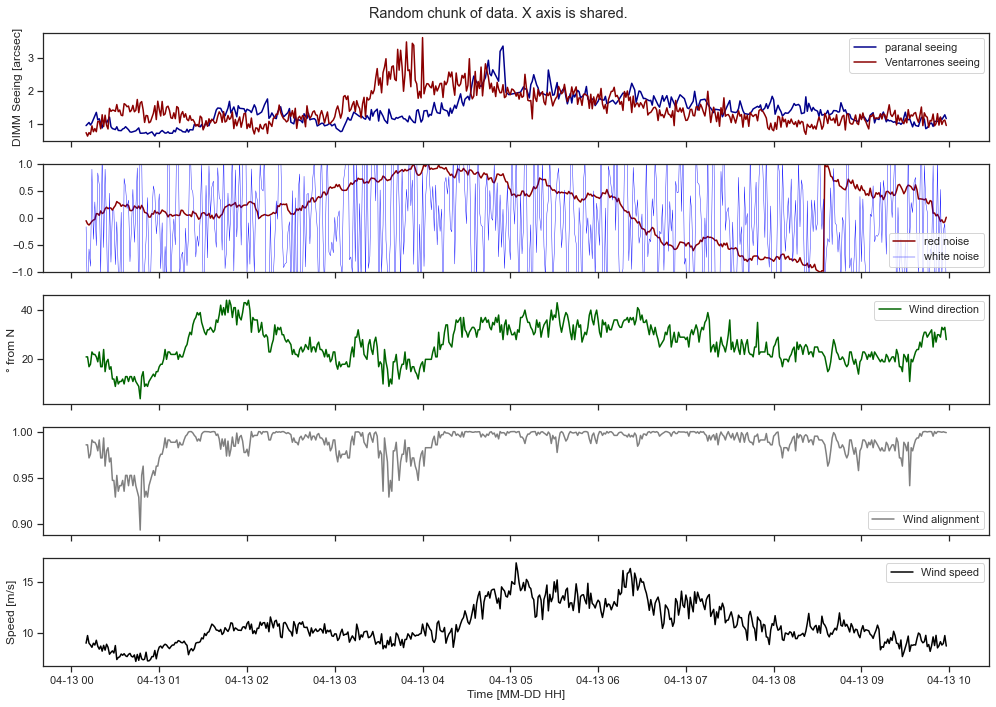

In [16]:
f, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(5, 1, sharex=True, figsize=(14, 10))
ax1.plot(
    chunked_df["DIMM Seeing [arcsec]"][10100:10689],
    label="paranal seeing",
    color="darkblue",
)
ax1.plot(
    chunked_df["Ventarrones Seeing [arcsec]"][10100:10689],
    label="Ventarrones seeing",
    color="darkred",
)
ax1.set_ylabel("DIMM Seeing [arcsec]")
ax1.legend()

ax2.plot(
    chunked_df["DIMM Seeing [arcsec]"].index[10100:10689],
    red_noise[10100:10689],
    label="red noise",
    color="darkred",
)
ax2.plot(
    chunked_df["DIMM Seeing [arcsec]"].index[10100:10689],
    white_noise[10100:10689],
    label="white noise",
    color="blue",
    linewidth=0.4,
)
ax2.set_ylim([-1, 1])
ax2.legend()


ax3.plot(
    chunked_df["Wind Direction at 30m (0/360) [deg]"][10100:10689],
    label="Wind direction",
    color="darkgreen",
)
ax3.set_ylabel("° from N")
ax3.legend()

ax4.plot(
    chunked_df["wind_alignment"][10100:10689],
    label="Wind alignment",
    color="grey",
)
ax4.legend()

ax5.plot(
    chunked_df["Wind Speed at 30m [m/s]"][10100:10689],
    label="Wind speed",
    color="black",
)
ax5.set_ylabel("Speed [m/s]")
ax5.set_xlabel("Time [MM-DD HH]")
ax5.legend()
f.suptitle("Random chunk of data. X axis is shared.")
f.set_tight_layout(True)
plt.show()

Above we are plotting a random chunk of the data. We can see that indeed we have managed to dynamically shift the Paranal data based on the wind speed, and also apply some noise to simulate perturbations.

## Conclusion

We have successfully simulated data at Ventarrones by dynamically shifting data at Paranal given the wind speed and direction at Paranal and the two sites' geographical coordinates. To do this we made use of functions from the `gis` and `dynlag` submodules of the Nowcast Library